# Predicting Changes in Spending Patterns Using COVID Data

**Import Libraries**

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [2]:
# load the data
path = os.getcwd()
daily_ny = pd.read_csv(path + '/daily_data_NewYork.csv')
mobility_ny = pd.read_csv(path + '/NewYork_mobility.csv')

### Data Preparation

In [3]:
# focus on areas of intereset
mobility_ny = mobility_ny[['date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline']]
daily_ny = daily_ny[['date_of_interest', 'CASE_COUNT']]
daily_ny = daily_ny.rename(columns={'date_of_interest':'date'})

# match datetime format
mobility_ny['date'] = pd.to_datetime(mobility_ny.date)
daily_ny['date'] = pd.to_datetime(daily_ny.date)
print(mobility_ny.shape)
print(daily_ny.shape)

(53802, 4)
(855, 2)


In [4]:
# merge the dataframes
df = mobility_ny.merge(daily_ny, how='left', on='date')
df = df.dropna().reset_index()
df = df.drop(columns='index')

print(df.shape)
print(df.columns)

(26776, 5)
Index(['date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline', 'CASE_COUNT'],
      dtype='object')


### Exploratory Data Analysis

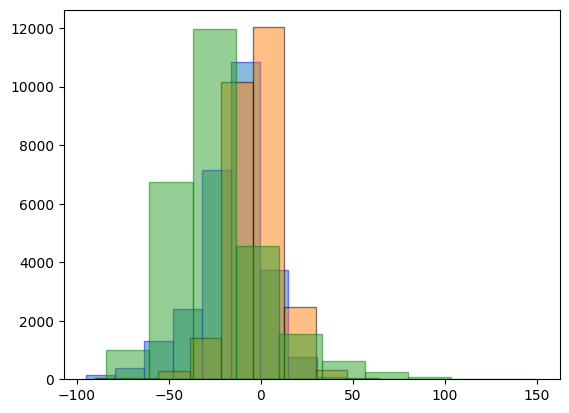

In [5]:
plt.hist(df.retail_and_recreation_percent_change_from_baseline, alpha=0.5, edgecolor='blue')
plt.hist(df.grocery_and_pharmacy_percent_change_from_baseline, alpha=0.5, edgecolor='black')
plt.hist(df.transit_stations_percent_change_from_baseline, alpha=0.5, edgecolor='green')
plt.show()

Spending changes in the retail/recreation and grocery/pharmacy are close to normal distribution with no skew, while transit follows a normal distribution and is skewed right.

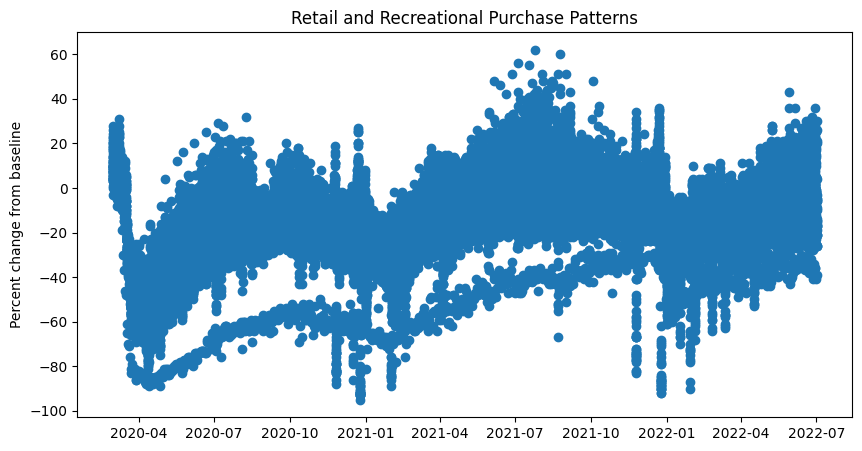

In [6]:
plt.figure(figsize=(10,5))
plt.scatter(df.date, df.retail_and_recreation_percent_change_from_baseline)
plt.title('Retail and Recreational Purchase Patterns')
plt.ylabel('Percent change from baseline')
plt.show()

The graph depicts that spending changes fluctuate the most during the earlier months in the year and increase in spending throughout the the remainder of the year.

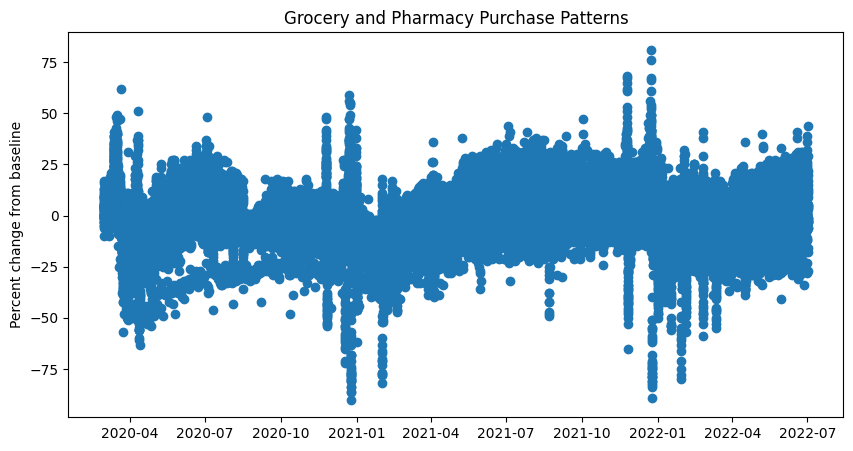

In [7]:
plt.figure(figsize=(10,5))
plt.scatter(df.date, df.grocery_and_pharmacy_percent_change_from_baseline)
plt.title('Grocery and Pharmacy Purchase Patterns')
plt.ylabel('Percent change from baseline')
plt.show()

Grocery and pharmacy spending is more consistent year round, but also has strong fluctuations during the beginning of each year.

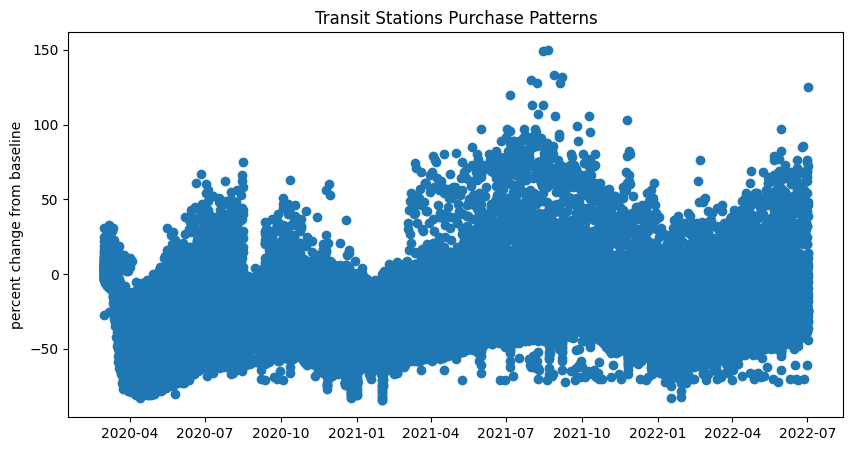

In [8]:
plt.figure(figsize=(10,5))
plt.scatter(df.date, df.transit_stations_percent_change_from_baseline)
plt.title('Transit Stations Purchase Patterns')
plt.ylabel('percent change from baseline')
plt.show()

Transit purchasing patterns are more ambiguous as it covers a wide range of spending changes between the given date ranges.

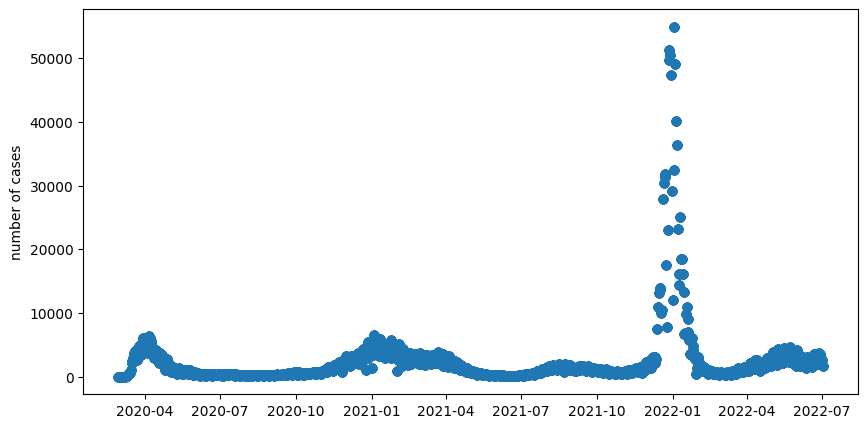

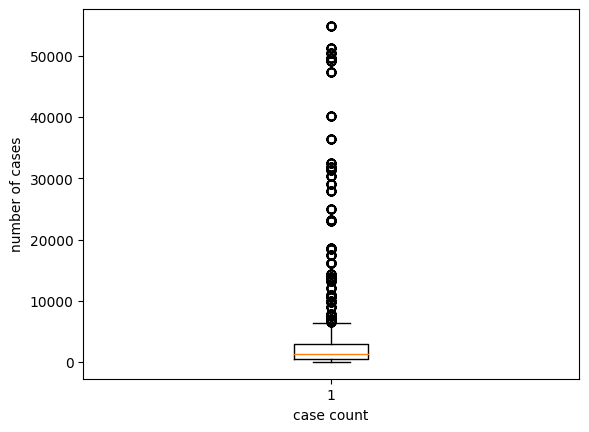

In [9]:
plt.figure(figsize=(10,5))
plt.scatter(df.date, df.CASE_COUNT)
plt.ylabel('number of cases')
plt.show()

plt.boxplot(df.CASE_COUNT)
plt.ylabel('number of cases')
plt.xlabel('case count')
plt.show()

Looking into the number of cases by date, there are more cases during the earlier parts of the year. Also the beginning of 2022 had a major spike in the cases, resulting in many outliers. Although the outliers exist, they are natural variations within the population, so these observations were left in the dataset.

### Data Modeling & Evaluation

**Feature Engineering**

Because the number of cases is the variable being used to predict the changes in purchasing patterns, feature engineering is a crucial step in the process. Adding appropriate features can lead to more accurate predictions and provides the model with more context to recognize patterns within the dataset.

In [10]:
# feature engineering
df['month'] = df.date.dt.month
df['day'] = df.date.dt.day
df['year'] = df.date.dt.year
df['lag_1'] = df.CASE_COUNT.shift(1)
df['monthly_average'] = df.groupby(df['date'].dt.to_period('M'))['CASE_COUNT'].transform('mean')
df['weekly_average'] = df.groupby(df['date'].dt.to_period('W'))['CASE_COUNT'].transform('mean')
df['weekly_moving_average'] = df['CASE_COUNT'].rolling(window=7, min_periods=1).mean()
df['exponential_moving_average'] = df['CASE_COUNT'].ewm(span=7, adjust=False).mean()

# accomodate the lag_1 column by removing the first row
df = df.iloc[1:]

Date has been split into 3 columns, so the model can interpret patterns by month, date, and year. Weekly, monthly and moving averages were incorprated to capture short-term patterns and the exponential moving average is to put an emphasis on more recent data.

In [11]:
# preprocess and split the data
features = ['month', 'day', 'year', 'CASE_COUNT', 'lag_1', 'monthly_average', 'weekly_average', 'weekly_moving_average', 'exponential_moving_average']
X = df[features]
y = df['retail_and_recreation_percent_change_from_baseline']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=1)

In [12]:
# use naive baseline model
baseline = y.mean()
baseline_predictions = [baseline] * len(X)

base_mae = metrics.mean_absolute_error(y, baseline_predictions)
base_mse = metrics.mean_squared_error(y, baseline_predictions)
print('Mean Absolute Error: %f'%(base_mae))
print('Mean Squared Error: %f'%(base_mse))

Mean Absolute Error: 13.980032
Mean Squared Error: 350.084810


In [13]:
# create the model
r_model = RandomForestRegressor()
r_model.fit(X_train, y_train)

r_preds = cross_val_predict(r_model, X_valid, y_valid, cv=5)
r_mae = metrics.mean_absolute_error(y_valid, r_preds)
r_mse = metrics.mean_squared_error(y_valid, r_preds)
print('Mean Absolute Error: %f'%(r_mae))
print('Mean Squared Error: %f'%(r_mse))

Mean Absolute Error: 9.142151
Mean Squared Error: 158.707371


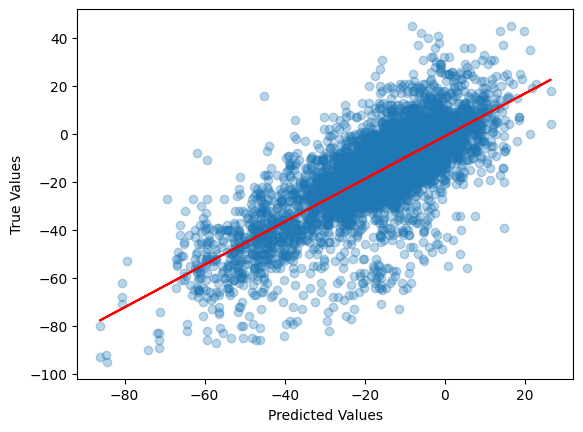

In [14]:
# visualize predictions
a, b = np.polyfit(r_preds, y_valid, 1)
plt.scatter(r_preds, y_valid, alpha=0.3)
plt.plot(r_preds, a*r_preds+b, color='red')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

Visualizing the predicted values against the true values, the slope of the best fit line and slight levels of variation suggests that the predicted values are close to the true values.

In [15]:
# evaluate spending changes in the grocery and pharmacy department
X = df[features]
y = df['grocery_and_pharmacy_percent_change_from_baseline']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=2)

# set the baseline metrics
baseline = y.mean()
baseline_predictions = [baseline] * len(X)

base_mae = metrics.mean_absolute_error(y, baseline_predictions)
base_mse = metrics.mean_squared_error(y, baseline_predictions)

print('Baseline Metrics')
print('Mean Absolute Error: %f'%(base_mae))
print('Mean Squared Error: %f'%(base_mse))
print('--------------------------------------------')

# create the model
g_model = RandomForestRegressor()
g_model.fit(X_train, y_train)

g_preds = cross_val_predict(g_model, X_valid, y_valid, cv=5)
g_mae = metrics.mean_absolute_error(y_valid, g_preds)
g_mse = metrics.mean_squared_error(y_valid, g_preds)
print('Mean Absolute Error: %f'%(g_mae))
print('Mean Squared Error: %f'%(g_mse))

Baseline Metrics
Mean Absolute Error: 9.932291
Mean Squared Error: 188.082570
--------------------------------------------
Mean Absolute Error: 7.470730
Mean Squared Error: 102.322166


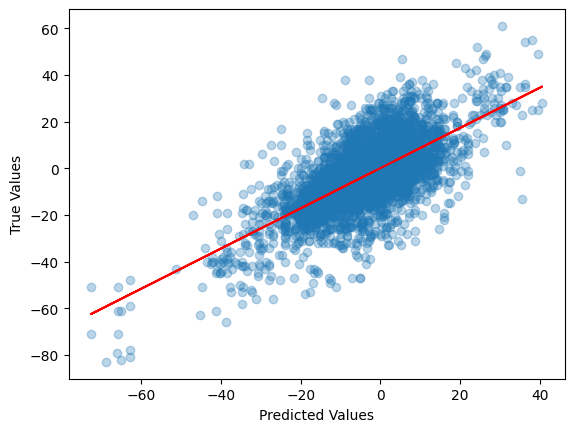

In [16]:
# visualize predictions
a, b = np.polyfit(g_preds, y_valid, 1)
plt.scatter(g_preds, y_valid, alpha=0.3)
plt.plot(g_preds, a*g_preds+b, color='red')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

The relationship between predicted and true values are diagonal which suggests that the predicted values are close to the true values. Although there is more variation and density in parts of the graph, the visualization shows a strong set of predicted values.

In [17]:
# evaluate spending changes in the transit department
X = df[features]
y = df['transit_stations_percent_change_from_baseline']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=2)

# set the baseline metrics
baseline = y.mean()
baseline_predictions = [baseline] * len(X)

base_mae = metrics.mean_absolute_error(y, baseline_predictions)
base_mse = metrics.mean_squared_error(y, baseline_predictions)

print('Baseline Metrics')
print('Mean Absolute Error: %f'%(base_mae))
print('Mean Squared Error: %f'%(base_mse))
print('--------------------------------------------')

# create the model
t_model = RandomForestRegressor()
t_model.fit(X_train, y_train)

t_preds = cross_val_predict(t_model, X_valid, y_valid, cv=5)
t_mae = metrics.mean_absolute_error(y_valid, t_preds)
t_mse = metrics.mean_squared_error(y_valid, t_preds)
print('Mean Absolute Error: %f'%(t_mae))
print('Mean Squared Error: %f'%(t_mse))

Baseline Metrics
Mean Absolute Error: 18.738541
Mean Squared Error: 643.934720
--------------------------------------------
Mean Absolute Error: 17.533535
Mean Squared Error: 567.725949


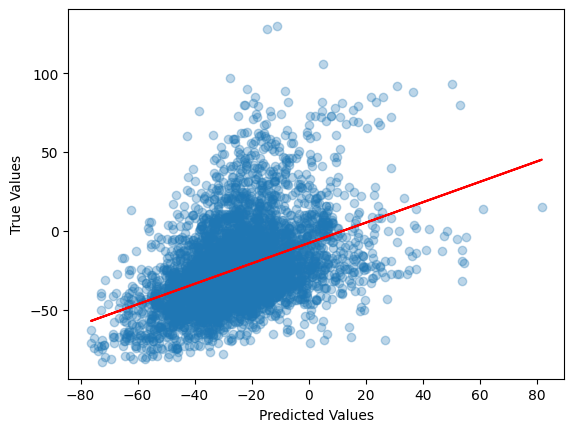

In [18]:
# visualize predictions
a, b = np.polyfit(t_preds, y_valid, 1)
plt.scatter(t_preds, y_valid, alpha=0.3)
plt.plot(t_preds, a*t_preds+b, color='red')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

Looking into the predictions with transit data, the variations and noise shows the disparity between predicted and true values. The variation makes the depiction look more circle-like than a diagonal line impying that the predictions were not very accurate. The MAE and MSE metrics also imply the predictions are close to random guessing.  